# <center>Trabajo Práctico Computacional 1:<br>Conceptos Básicos</center>

Grupo 9: Facundo Joaquı́n Garcı́a, Agustı́n Brusco, Eitan Sprejer

# Punto 1: Redes de interacción de proteínas

In [227]:
# Imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib_venn as venn
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

# Variables globales
GIANT_FORMAT = {"with_labels" : False,
                "node_size": 10, "node_color": "red", "edgecolors": "black",
                "linewidths": 0.25, "width": 0.25, "edge_color": "black"}
MIDLE_FORMAT = {"with_labels" : False,
                "node_size": 8, "node_color": "darkred", "edgecolors": "grey",
                "linewidths": 0.25, "width": 0.25, "edge_color": "grey"}
SMALL_FORMAT = {"with_labels" : False,
                "node_size": 5, "node_color": "firebrick", "edgecolors": "grey",
                "linewidths": 0.25, "width": 0.25, "edge_color": "grey"}


networks = ['AP-MS', 'LIT', 'Y2H']
files = [f'{name}.txt' for name in networks]
dataframes = [pd.read_csv(f'datasets/{filename}', delimiter="\t",
                          header=None, names=["source", "target"]) for filename in files]
# Cargamos todas las redes como grafos no dirigidos:
graphs = [nx.from_pandas_edgelist(df, create_using=nx.Graph) for df in dataframes]

## a) Comparación gráfica

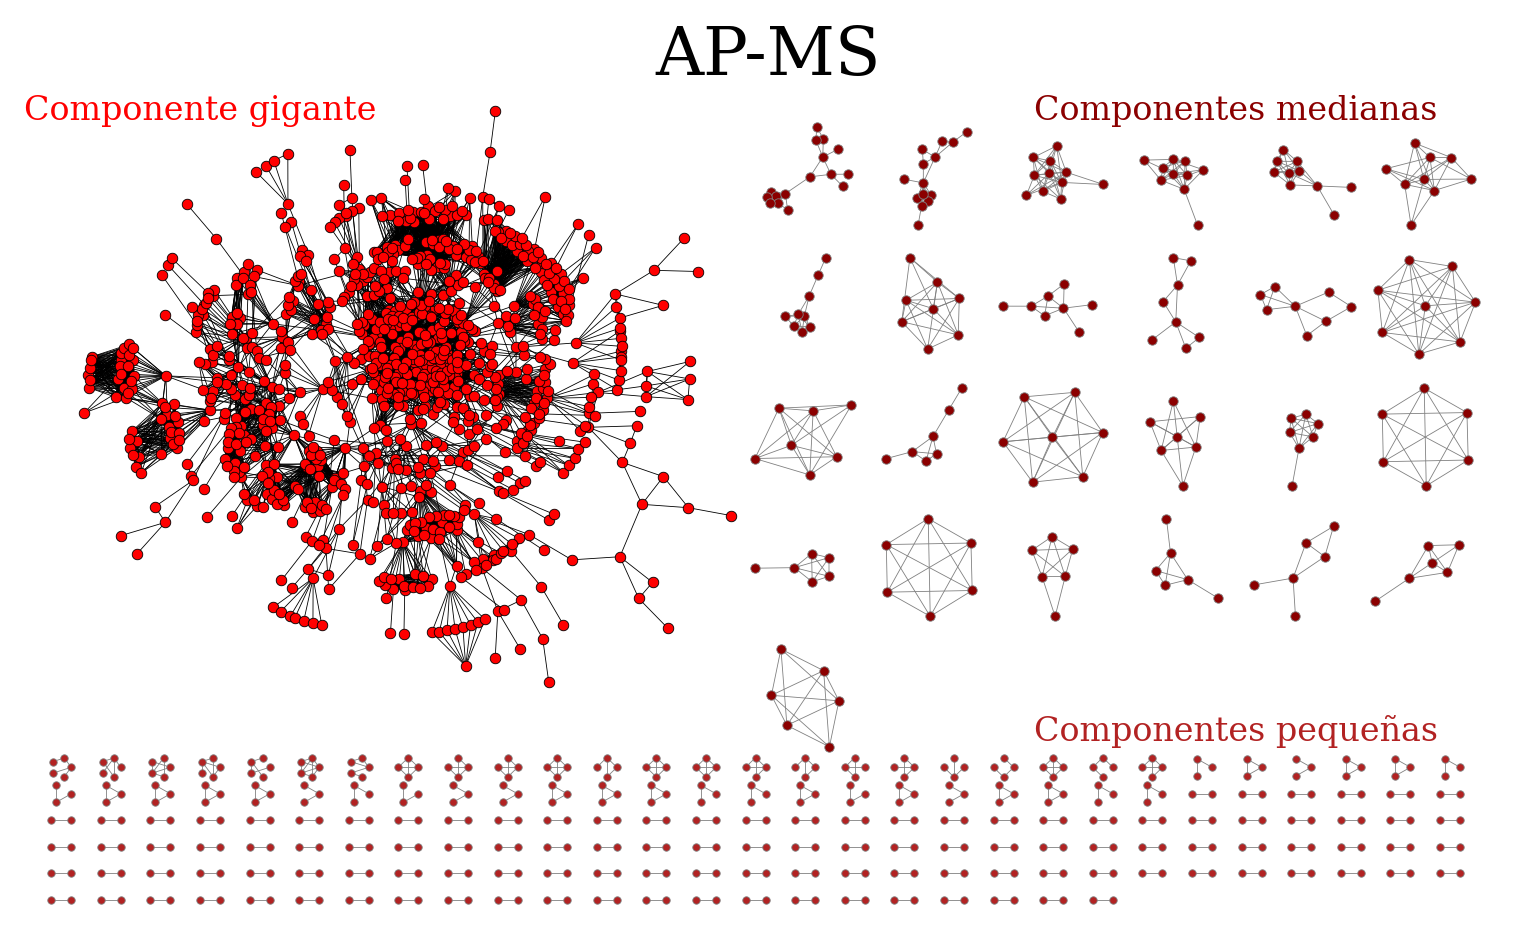

In [232]:


for net_idx in [0]:
    # Extracción de las componentes de la red:
    net_components = [graphs[net_idx].subgraph(c).copy() for c in sorted(nx.connected_components(graphs[net_idx]),
                                                                    key=len, reverse=True)]
    scale_arr = np.array([9, 16])/2
    fig = plt.figure(figsize=tuple(scale_arr[::-1]))

    # Gráfico de la componente gigante:
    plt.text(0, 10, 'Componente gigante', va='top', c=GIANT_FORMAT["node_color"])
    layout_giant = nx.layout.kamada_kawai_layout(net_components[0])
    main_layout = {k: v*scale_arr*0.5 + np.array([5/2, 13/2]) for k, v in layout_giant.items()}
    nx.draw(net_components[0], pos=main_layout, **GIANT_FORMAT)


    # Gráfico de las demas componentes:
    plt.text(9.5, 10, 'Componentes medianas', va='top', ha='right', c=MIDLE_FORMAT["node_color"])
    x0, y0 = 5.25, 9  # A la derecha las más grandes
    x1, y1 = x0, y0
    x_sep, y_sep = 5/6, 8/5
    off = np.array([x0, y0])
    for i, comp in enumerate(net_components[1:], start=1):
        if y1 < 2 or len(comp) <= 5:
            break
        l = nx.spring_layout(comp, seed=42)
        moved_l = {k: v*scale_arr*0.075 + off for k, v in l.items()}
        nx.draw(comp, pos=moved_l, **MIDLE_FORMAT)
        if x1 + x_sep >= 10:
            y1 -= y_sep
            x1 = x0
            off = np.array([x0, y1])
        else:
            x1 += x_sep
            off = np.array([x1, y1])
            
    plt.text(9.5, 2, 'Componentes pequeñas', va='bottom', ha='right', c=SMALL_FORMAT["node_color"])
    x0, y0 = 0.25, 1.75  # Abajo las más pequeñas
    x1, y1 = x0, y0
    x_sep, y_sep = 1/2, 1.3/4
    off = np.array([x0, y0])
    for j, comp in enumerate(net_components[i:], start=i):
        l = nx.circular_layout(comp)
        moved_l = {k: v*scale_arr*1.5e-2 + off for k, v in l.items()}
        nx.draw(comp, pos=moved_l, **SMALL_FORMAT)
        if x1 + x_sep >= 10:
            y1 -= y_sep
            x1 = x0
            off = np.array([x0, y1])
        else:
            x1 += 2*x_sep/3
            off = np.array([x1, y1])

    plt.xlim(0, 10)
    plt.ylim(0, 10)

    plt.title(networks[net_idx], fontsize=20)
    plt.show()

## b) Tabla de características

In [5]:
attrs = {}

for net, graph in zip(networks, graphs):
    attr = {}
    attr['node_number'] = len(graph.nodes)
    attr['edge_number'] = len(graph.edges)
    attr['directed'] = False  # REVISAR
    degrees = list(dict(graph.degree).values())
    attr['k_mean'] = np.mean(degrees)
    attr['k_min'] = np.min(degrees)
    attr['k_max'] = np.max(degrees)
    attr['density'] = 2*attr['edge_number']/(attr['node_number']*(attr['node_number']-1))
    attr['g_mean'] = nx.average_clustering(graph, count_zeros=True)
    attr['transitivity'] = nx.transitivity(graph)
    components = nx.connected_components(graph)
    diams = [nx.diameter(graph.subgraph(comp).copy()) for comp in components]
    attr['diameter'] = max(diams)
    attrs[net] = attr
    


In [6]:
pd.DataFrame(attrs).rename(index = {"node_number": "Numero de nodos",
                                    "edge_number": "Numero de enlaces",
                                    "directed": "Es dirigida?",
                                    "k_mean": "Grado medio",
                                    "k_max": "Grado máximo",
                                    "k_min": "Grado mínimo",
                                    "density": "Densidad",
                                    "g_mean": "Coeficiente de Clustering medio",
                                    "transitivity": "Coeficiente de Clustering global",
                                    "diameter": "Diámetro"}).T

,Numero de nodos,Numero de enlaces,Es dirigida?,Grado medio,Grado mínimo,Grado máximo,Densidad,Coeficiente de Clustering medio,Coeficiente de Clustering global,Diámetro
AP-MS,1622,9070,False,11.183724,1,127,0.006899,0.554636,0.61859,15
LIT,1536,2925,False,3.808594,1,40,0.002481,0.292492,0.346193,19
Y2H,2018,2930,False,2.903865,1,91,0.00144,0.046194,0.023614,14


## c) Análisis de resultados

## d) Diagramas de Venn

In [57]:
nodes_apms = pd.concat([dataframes[0]["source"],dataframes[0]["target"]]).unique() #0: APMS
nodes_lit  = pd.concat([dataframes[1]["source"],dataframes[1]["target"]]).unique() #1: LIT
nodes_y2h  = pd.concat([dataframes[2]["source"],dataframes[2]["target"]]).unique() #2: Y2H

edges_apms = [tuple(sorted(i)) for i in graphs[0].edges]
edges_lit  = [tuple(sorted(i)) for i in graphs[1].edges]
edges_y2h  = [tuple(sorted(i)) for i in graphs[2].edges]

Text(0.5, 1.0, 'Enlaces')

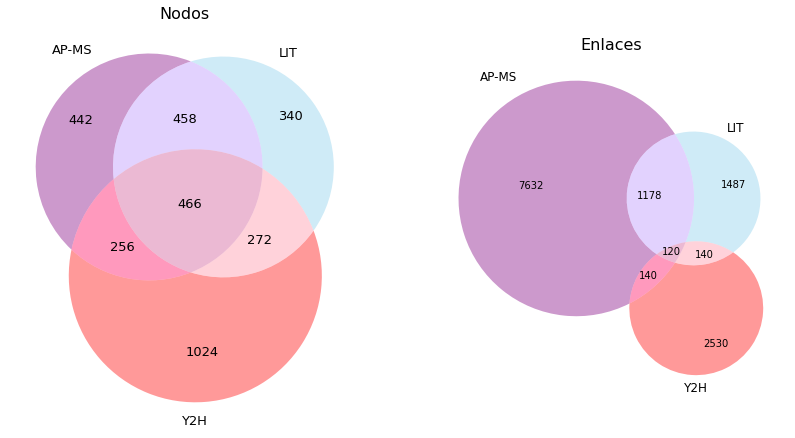

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (14, 10))
fig.set_facecolor("white")

v_nodes = venn.venn3([set(nodes_apms), set(nodes_lit), set(nodes_y2h)], set_labels = ('AP-MS', 'LIT', 'Y2H'),
          set_colors =("Purple", "Skyblue", "Red"), ax = ax[0])

v_edges = venn.venn3([set(edges_apms), set(edges_lit), set(edges_y2h)], set_labels = ('AP-MS', 'LIT', 'Y2H'),
          set_colors =("Purple", "Skyblue", "Red"), ax = ax[1])

#v.get_patch_by_id('100').set_color("red")

for text in ax[0].texts:
    text.set_fontsize(13)

ax[0].set_title("Nodos", fontsize = 16)
ax[1].set_title("Enlaces", fontsize = 16)